In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
link = pd.read_csv(os.getcwd()+'/ml-latest-small/links.csv')
print(link.shape)
link.head()

(9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
movies = pd.read_csv(os.getcwd()+'/ml-latest-small/movies.csv')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv(os.getcwd()+'/ml-latest-small/ratings.csv')
print(ratings.shape)
print(ratings['movieId'].nunique())
print(ratings['userId'].nunique())
ratings.head()

(100836, 4)
9724
610


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags = pd.read_csv(os.getcwd()+'/ml-latest-small/tags.csv')
print(tags.shape)
tags.head()

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# Data Exploration 

In [6]:
print('The number of missing rating: ', ratings['rating'].isna().sum())
print('The rating scores: ', sorted(ratings['rating'].unique()))

The number of missing rating:  0
The rating scores:  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


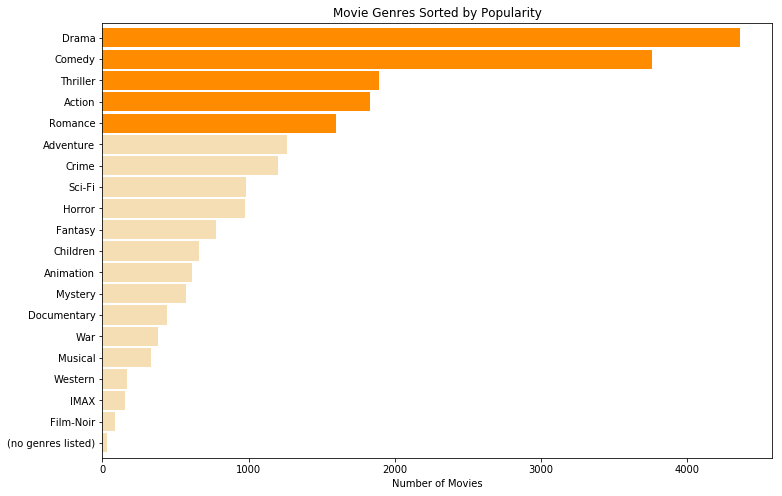

In [7]:
gen_list = movies['genres'].str.split('|', expand = True).stack().value_counts(ascending = True)
colors = np.where(gen_list > gen_list[-6], 'darkorange', 'wheat')
gen_list.plot(kind = 'barh', width = 0.9, color=colors, use_index=True, figsize=(12,8))
plt.title('Movie Genres Sorted by Popularity')
plt.xlabel('Number of Movies')
plt.show()

In [8]:
ratings['year'] = [datetime.datetime.utcfromtimestamp(ts).date().year for ts in ratings.timestamp]
rating_year = ratings.groupby(['year'])['rating'].mean()
m_rating = ratings['rating'].mean()

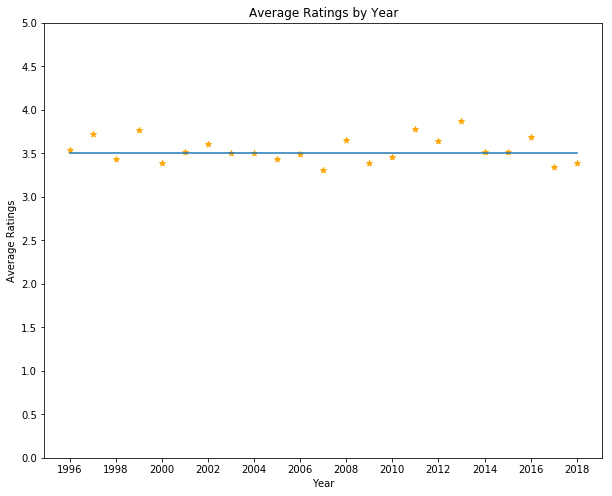

In [9]:
plt.figure(figsize = (10, 8))
plt.scatter(rating_year.index, rating_year, marker='*', color='orange')
plt.plot(rating_year.index, [m_rating]*len(rating_year.index))
plt.yticks(np.arange(0, 5.5, step = 0.5))
plt.xticks(np.arange(1996, 2019, step = 2))
plt.xlabel('Year')
plt.ylabel('Average Ratings')
plt.title('Average Ratings by Year')

#plt.show()
plt.savefig('year.png')

In [10]:
n_ratPuser = ratings.groupby(['userId'])['movieId'].count().sort_values()
print('The min number per user rated: ', n_ratPuser.min())
print('The max number per user rated: ', n_ratPuser.max())
print('The average rating per user: %0.3f' %(ratings.shape[0]/ratings['userId'].nunique()))

The min number per user rated:  20
The max number per user rated:  2698
The average rating per user: 165.305


# Data Preparation

In [11]:
rating_ave = ratings.groupby(['movieId'])['rating'].aggregate(['mean','count']).sort_values(by='count', ascending=True)
print('The number of rating for 5.0-star movies: ', rating_ave[rating_ave['mean'] == 5.0]['count'].unique())
print('The number of rating for 0.5-star movies: ', rating_ave[rating_ave['mean'] == 0.5]['count'].unique())

The number of rating for 5.0-star movies:  [1 2]
The number of rating for 0.5-star movies:  [1 2]


In [12]:
rating_count = rating_ave['count'].value_counts()
print('The number of rating under 10: ', rating_count.head(10).sum())

The number of rating under 10:  7609


# Collaborative Filtering

### User-Movie Matrix

In [13]:
um = pd.pivot_table(ratings, values='rating', index='userId', columns='movieId')
um.fillna(0, inplace=True)
print(um.shape)
um.head()

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
sparsity = ratings.shape[0]/um.size
print('Sparsity: {:.2f}%'.format(sparsity*100)) ## 1.7% of the user-movie ratings have a value.

Sparsity: 1.70%


### Train-Test Split

In [15]:
train_um = um.values.copy()
test_um = np.zeros(um.shape)

## move 10 ratings of each user into test data
for user in range(um.shape[0]):
    test_rating = np.random.choice(um.values[user, :].nonzero()[0], size=10, replace=False)
    train_um[user, test_rating] = 0
    test_um[user, test_rating] = um.values[user, test_rating]
    
print(test_um.shape)
print(train_um.shape)

(610, 9724)
(610, 9724)


In [16]:
assert(np.all((train_um * test_um) == 0)) ## test train and test are disjoint

### Consine similarity

In [17]:
def similarity(user_item, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = user_item.dot(user_item.T) + epsilon
    elif kind == 'item':
        sim = user_item.T.dot(user_item) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [18]:
user_sim = similarity(train_um, kind='user')
item_sim = similarity(train_um, kind='item')

In [19]:
print(user_sim.shape)
print(item_sim.shape)

(610, 610)
(9724, 9724)


#### Build-in Package

In [20]:
# user_sim = 1-pairwise_distances(train_um, metric='cosine')
# item_sim = 1-pairwise_distances(train_um.T, metric='cosine')

In [21]:
# print(user_sim.shape)
# print(item_sim.shape)

### Prediction

In [22]:
def predict(user_item, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(user_item) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return user_item.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [23]:
user_pred = predict(train_um, user_sim, kind='user')
item_pred = predict(train_um, item_sim, kind='item')

### Recommendations

In [24]:
def recommend_movies(prediction, userid, rating, n_recom):
    
    # Get and sort the user's predictions
    pred = pd.DataFrame(prediction, index=um.index)
    pred_sort = pred.loc[userid].sort_values(ascending=False)
    pred_sort.rename('prediction', inplace=True)
    
    user_data = rating[rating.userId == userid]
    user_data = user_data.merge(movies, how = 'left', on = 'movieId').sort_values(['rating'], ascending=False)
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    notsee = movies[~movies['movieId'].isin(user_data['movieId'])]
    notsee = notsee.merge(pd.DataFrame(pred_sort), how='left', left_on='movieId', right_index=True)
    notsee = notsee.sort_values('prediction', ascending=False)
    recommendation = notsee.iloc[:n_recom, :-1]
    
    return recommendation

In [25]:
userid = 357

In [26]:
recommend_movies(user_pred, userid, ratings, 5)

,movieId,title,genres
273,314,"Secret of Roan Inish, The (1994)",Children|Drama|Fantasy|Mystery
221,257,Just Cause (1995),Mystery|Thriller
445,510,Poetic Justice (1993),Drama
1416,1938,"Lost Weekend, The (1945)",Drama
191,224,Don Juan DeMarco (1995),Comedy|Drama|Romance


In [27]:
recommend_movies(item_pred, userid, ratings, 5)

,movieId,title,genres
3752,5226,All the Right Moves (1983),Drama|Romance
5023,7811,Babylon 5: The River of Souls (1998),Drama|Sci-Fi
3836,5384,I Want to Live! (1958),Crime|Drama
2421,3219,Pacific Heights (1990),Mystery|Thriller
4170,6005,Blue Collar Comedy Tour: The Movie (2003),Comedy|Documentary


### Evaluation: RMSE

In [28]:
def get_rmse(pred, act):
    # Ignore nonzero terms.
    pred = pred[act.nonzero()].flatten()
    act = act[act.nonzero()].flatten()
    rmse = mean_squared_error(pred, act)**0.5
    return rmse

In [29]:
print('User-based RMSE: ', get_rmse(user_pred, test_um))
print('Item-based RMSE: ', get_rmse(item_pred, test_um))

User-based RMSE:  3.1530631644599887
Item-based RMSE:  3.6983131198565036
